In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

# embedding ideas

This notebook has some code to get started, and some ideas on how to achieve the following goals:

- Building a KNN classifer
- Annotating each track

## setup

### downloading the dataset

Make sure that you have the dataset downloaded locally.
At the root of the project, run this command:

```bash
gsutil -m rsync \
    gs://birdclef-2023/data/processed/birdclef-2023/train_embeddings/consolidated_v3_pre1/ \
    data/processed/birdclef-2023/train_embeddings/consolidated_v3_pre1/ 
```

### using spark

In [2]:
from birdclef.utils import get_spark
from pyspark.sql import functions as F

# modify cores and memory as needed
spark = get_spark(cores=8, memory="16g")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/13 18:45:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
import os

print(os.getcwd())

/home/mgustine/birdclef-2023/notebooks


In [7]:
path = "../data/processed/birdclef-2023/train_embeddings/consolidated_v3/"
df = spark.read.parquet(path)
df.printSchema()
df.count()

root
 |-- species: string (nullable = true)
 |-- track_stem: string (nullable = true)
 |-- track_type: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- embedding: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- prediction_vec: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- predictions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- rank: long (nullable = true)
 |    |    |-- index: long (nullable = true)
 |    |    |-- label: string (nullable = true)
 |    |    |-- mapped_label: string (nullable = true)
 |    |    |-- probability: double (nullable = true)
 |-- start_time: long (nullable = true)
 |-- energy: double (nullable = true)



1198860

In [9]:
df.show(5, vertical=True, truncate=80)

-RECORD 0------------------------------------------------------------------------------------------
 species        | wlwwar                                                                           
 track_stem     | XC475384_part003                                                                 
 track_type     | original                                                                         
 track_name     | wlwwar/XC475384_part003.mp3                                                      
 embedding      | [0.6336879134178162, 0.699510395526886, 0.43676260113716125, 1.18983256816864... 
 prediction_vec | [-10.213504791259766, -9.510478973388672, -12.938481330871582, -9.79550075531... 
 predictions    | [{0, 2005, Nucifraga caryocatactes_Eurasian Nutcracker, eurnut1, 0.0690114870... 
 start_time     | 18                                                                               
 energy         | 1.2206932306289673                                                               


In [14]:
df.show()

+-------+----------------+----------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|species|      track_stem|track_type|          track_name|           embedding|      prediction_vec|         predictions|start_time|              energy|
+-------+----------------+----------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
| wlwwar|XC475384_part003|  original|wlwwar/XC475384_p...|[0.63368791341781...|[-10.213504791259...|[{0, 2005, Nucifr...|        18|  1.2206932306289673|
| grecor|XC629875_part015|   source1|grecor/XC629875_p...|[0.47638714313507...|[-8.6292562484741...|[{0, 291, Atlanti...|        60| 0.02938658744096756|
| grecor|XC629875_part006|   source3|grecor/XC629875_p...|[1.27789175510406...|[-13.741335868835...|[{0, 1079, Egrett...|        87|  1.1638777256011963|
| wlwwar|XC475384_part000|   source0|wlwwar/XC475384_p...|[1.04215753078460.

In [10]:
df.groupBy("species").count().orderBy(F.desc("count")).show(20)

+-------+------+
|species| count|
+-------+------+
|thrnig1|104440|
| wlwwar| 57260|
|eubeat1| 52810|
| hoopoe| 42995|
|combuz1| 42650|
|cohmar1| 35210|
| barswa| 33355|
|eaywag1| 29165|
| comsan| 27180|
|combul2| 24855|
| woosan| 23710|
|rbsrob1| 19910|
|blakit1| 19880|
| litegr| 16710|
| grecor| 16030|
|somgre1| 15280|
|gnbcam2| 13945|
|rerswa1| 13660|
|colsun2| 12545|
|carcha1| 12440|
+-------+------+
only showing top 20 rows



In [11]:
# use a sample of tracks that will make things easier to work with

sample = df.where("species in ('woosan', 'blakit1', 'rbsrob1')").cache()
sample.count()

63500

## plot of embeddings of high confidence prediction

In [12]:
from pyspark.sql import Window, functions as F

# keep the track_type for each
highest_energy_channel = (
    sample
    # get the track stem without the part
    .withColumn("original_track_stem", F.split(F.col("track_stem"), "_").getItem(0))
    .where("track_type != 'original'")
    # get the track type that has the most energy
    .withColumn(
        "rank",
        F.rank().over(
            Window.partitionBy("original_track_stem").orderBy(F.desc("energy"))
        ),
    )
    # keep the first row
    .where(F.col("rank") == 1)
    # drop the rank column
    .select("species", "track_stem", "track_type")
    .distinct()
)

highest_energy_channel.show()

+-------+----------------+----------+
|species|      track_stem|track_type|
+-------+----------------+----------+
| woosan|        XC146456|   source2|
|blakit1|        XC572730|   source0|
|rbsrob1|        XC363495|   source1|
|blakit1|XC511559_part000|   source3|
| woosan|        XC647846|   source3|
|rbsrob1|        XC756771|   source0|
| woosan|        XC587077|   source0|
|blakit1|        XC138441|   source3|
| woosan|        XC500452|   source0|
| woosan|        XC747301|   source2|
|blakit1|        XC292781|   source0|
|blakit1|        XC485012|   source0|
|rbsrob1|        XC523609|   source3|
| woosan|        XC381829|   source0|
| woosan|        XC184898|   source0|
|blakit1|        XC418986|   source0|
|rbsrob1|        XC467151|   source0|
|rbsrob1|        XC547963|   source0|
| woosan|        XC575862|   source2|
| woosan|        XC747318|   source2|
+-------+----------------+----------+
only showing top 20 rows



In [13]:
# get the highest predictions by exploding the values

exploded_embeddings = (
    sample
    # join against the highest energy channel
    .join(
        highest_energy_channel,
        on=["species", "track_stem", "track_type"],
        how="inner",
    )
    # explode the embeddings, these are ordered by confidence
    .withColumn("predictions", F.explode("predictions")).select(
        "species",
        "track_stem",
        "track_type",
        "start_time",
        "track_name",
        "embedding",
        "predictions.*",
    )
    # simplifying assumption: we assume the prediction with the highest confidence is the true label
    .where("rank = 0 and probability > 0.5")
)

exploded_embeddings.drop("embedding").show()

+-------+----------------+----------+----------+--------------------+----+-----+--------------------+------------+------------------+
|species|      track_stem|track_type|start_time|          track_name|rank|index|               label|mapped_label|       probability|
+-------+----------------+----------+----------+--------------------+----+-----+--------------------+------------+------------------+
|blakit1|        XC511558|   source0|       126|blakit1/XC511558_...|   0| 1817|Milvus migrans_Bl...|     blakit1|0.6752714514732361|
|rbsrob1|        XC665538|   source3|        81|rbsrob1/XC665538_...|   0|  592|Chalcomitra seneg...|     sccsun2|0.9221712350845337|
| woosan|XC664809_part001|   source0|        30|woosan/XC664809_p...|   0| 3121|Tringa glareola_W...|      woosan|0.9884689450263977|
| woosan|XC664809_part001|   source0|        81|woosan/XC664809_p...|   0| 3121|Tringa glareola_W...|      woosan| 0.816118061542511|
|blakit1|XC542603_part000|   source1|        33|blakit1/XC5426

In [15]:
# percentage of clips that have a prediction of any kind
positive = exploded_embeddings.count()
total = sample.count()
positive / total * 100

5.722834645669291

In [16]:
predictions = exploded_embeddings.select(
    "species", "probability", "embedding"
).toPandas()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.preprocessing import LabelEncoder

# get the embeddings
X = np.stack(predictions.embedding.values)

# get the species
species = predictions.species.values
le = LabelEncoder()
y = le.fit_transform(species)

# fit the umap model
umap = UMAP(n_components=2)
X_umap = umap.fit_transform(X)

/home/mgustine/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-13 19:06:36.976695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 19:06:40.699079: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-13 19:06:53.095457: W tensorflow/compiler/xla/stream_executor/platform/default/dso

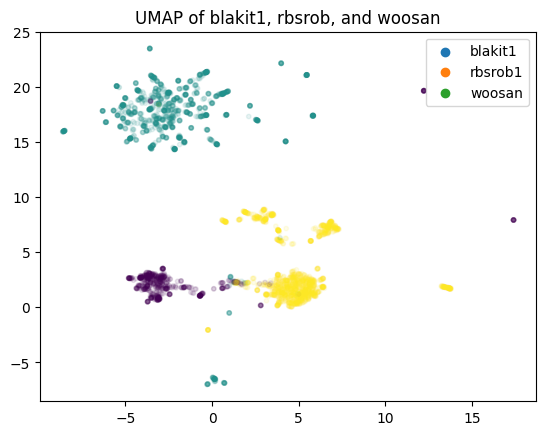

In [18]:
# plot the results
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, s=10, alpha=0.1)
# add dummy plot with label for each species
for i, species in enumerate(le.classes_):
    plt.scatter([], [], label=species)
plt.legend()
plt.title("UMAP of blakit1, rbsrob, and woosan")
plt.show()

If we wanted to find the most representative points of each of these species, we could compute the K-means of each species.
We would also want to take care to find all of the points are noisy (human voices, machines, dogs, footsteps, environmental, etc) and create a separate no-call class for them.

## labels from prediction logits

Instead of using the predictions struct, we can derive probabilities from the raw prediction logits.
This could be useful if we're looking to analyze a specific class across all the tracks.

In [21]:
from birdclef import birdnet

# labels = birdnet.load_labels("../vendor/BirdNET-Analyzer")
# mapped_labels = birdnet.load_mapped_labels("../vendor/BirdNET-Analyzer")

labels = birdnet.load_labels("../data/models/birdnet-analyzer-pruned")
mapped_labels = birdnet.load_mapped_labels("../data/models/birdnet-analyzer-pruned")
list(zip(labels, mapped_labels))[:20]

[('Abroscopus albogularis_Rufous-faced Warbler', 'rufwar1'),
 ('Abroscopus superciliaris_Yellow-bellied Warbler', 'yebwar1'),
 ('Aburria aburri_Wattled Guan', 'watgua1'),
 ('Acanthagenys rufogularis_Spiny-cheeked Honeyeater', 'spchon1'),
 ('Acanthis cabaret_Lesser Redpoll', 'lesred1'),
 ('Acanthis flammea_Common Redpoll', 'comred'),
 ('Acanthis hornemanni_Hoary Redpoll', 'hoared'),
 ('Acanthiza chrysorrhoa_Yellow-rumped Thornbill', 'yertho1'),
 ('Acanthiza ewingii_Tasmanian Thornbill', 'tastho1'),
 ('Acanthiza pusilla_Brown Thornbill', 'brotho1'),
 ('Acanthiza reguloides_Buff-rumped Thornbill', 'burtho1'),
 ('Acanthorhynchus tenuirostris_Eastern Spinebill', 'easspi1'),
 ('Accipiter badius_Shikra', 'shikra1'),
 ('Accipiter bicolor_Bicolored Hawk', 'bichaw1'),
 ("Accipiter cooperii_Cooper's Hawk", 'coohaw'),
 ('Accipiter fasciatus_Brown Goshawk', 'brogos1'),
 ('Accipiter gentilis_Northern Goshawk', 'norgos'),
 ('Accipiter nisus_Eurasian Sparrowhawk', 'eurspa1'),
 ('Accipiter striatus_Sha

In [22]:
# label with human voice
[(i, x) for i, x in enumerate(labels) if "human" in x.lower()]

[(1449, 'Human non-vocal_Human non-vocal'),
 (1450, 'Human vocal_Human vocal'),
 (1451, 'Human whistle_Human whistle')]

In [23]:
label_df = spark.createDataFrame(
    [
        {
            "label": label,
            "mapped_label": mapped_label,
            "index": i,
        }
        for i, (label, mapped_label) in enumerate(zip(labels, mapped_labels))
    ]
)
label_df.show(n=5)

+-----+--------------------+------------+
|index|               label|mapped_label|
+-----+--------------------+------------+
|    0|Abroscopus albogu...|     rufwar1|
|    1|Abroscopus superc...|     yebwar1|
|    2|Aburria aburri_Wa...|     watgua1|
|    3|Acanthagenys rufo...|     spchon1|
|    4|Acanthis cabaret_...|     lesred1|
+-----+--------------------+------------+
only showing top 5 rows



In [24]:
human_vocals = (
    sample
    # explode the predictions with their indices
    .select(
        "species",
        "track_name",
        "start_time",
        F.posexplode("prediction_vec").alias("index", "logit"),
    )
    # join with the labels, in case we want to use it for anything
    .join(label_df, on="index", how="inner")
    # now only keep human vocals
    .where("index = 1450")
    # and convert the logit to a probability via sigmoid
    .withColumn("probability", F.expr("1/(1+exp(-logit))"))
).toPandas()

human_vocals

,index,species,track_name,start_time,logit,label,mapped_label,probability
0,1450,blakit1,blakit1/XC740481_part000_source2.mp3,60,-9.323709,Human vocal_Human vocal,humvoc,0.000089
1,1450,blakit1,blakit1/XC740481_part002_source2.mp3,105,-8.242433,Human vocal_Human vocal,humvoc,0.000263
2,1450,blakit1,blakit1/XC740481_part003_source0.mp3,30,-10.041925,Human vocal_Human vocal,humvoc,0.000044
3,1450,blakit1,blakit1/XC740481_part003_source3.mp3,57,-9.478200,Human vocal_Human vocal,humvoc,0.000076
4,1450,blakit1,blakit1/XC740481_part000_source1.mp3,60,-10.683513,Human vocal_Human vocal,humvoc,0.000023
...,...,...,...,...,...,...,...,...
63495,1450,woosan,woosan/XC580751_source3.mp3,0,-10.280706,Human vocal_Human vocal,humvoc,0.000034
63496,1450,woosan,woosan/XC376849.mp3,0,-11.883453,Human vocal_Human vocal,humvoc,0.000007
63497,1450,woosan,woosan/XC557396_source0.mp3,3,-7.679912,Human vocal_Human vocal,humvoc,0.000462
63498,1450,woosan,woosan/XC554677_source2.mp3,3,-8.163547,Human vocal_Human vocal,humvoc,0.000285


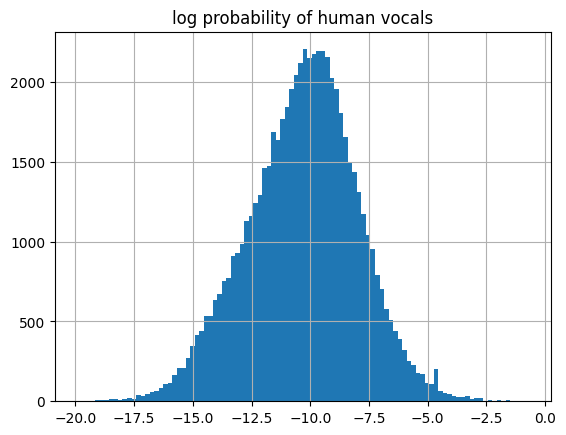

In [25]:
np.log(human_vocals.probability).hist(bins=100)
plt.title("log probability of human vocals")
plt.show()

In [26]:
human_vocals[human_vocals.probability > 0.2].sort_values("probability", ascending=False)

,index,species,track_name,start_time,logit,label,mapped_label,probability
34160,1450,rbsrob1,rbsrob1/XC393114_source2.mp3,36,-0.051290,Human vocal_Human vocal,humvoc,0.487180
15919,1450,woosan,woosan/XC567028_source2.mp3,3,-0.207987,Human vocal_Human vocal,humvoc,0.448190
21323,1450,rbsrob1,rbsrob1/XC393114_source2.mp3,30,-0.544033,Human vocal_Human vocal,humvoc,0.367250
23288,1450,rbsrob1,rbsrob1/XC624181_source3.mp3,27,-0.795864,Human vocal_Human vocal,humvoc,0.310911
25275,1450,rbsrob1,rbsrob1/XC393114_source2.mp3,15,-0.836876,Human vocal_Human vocal,humvoc,0.302193
46966,1450,blakit1,blakit1/XC442940_source2.mp3,3,-0.877798,Human vocal_Human vocal,humvoc,0.293634
1862,1450,rbsrob1,rbsrob1/XC382932_source2.mp3,6,-0.971475,Human vocal_Human vocal,humvoc,0.274587
30174,1450,rbsrob1,rbsrob1/XC624181_source3.mp3,15,-0.987376,Human vocal_Human vocal,humvoc,0.271431
17411,1450,woosan,woosan/XC345156_source2.mp3,33,-1.035372,Human vocal_Human vocal,humvoc,0.262044
39112,1450,rbsrob1,rbsrob1/XC624181_source3.mp3,18,-1.160185,Human vocal_Human vocal,humvoc,0.238634


In [28]:
# let's listen to the audio
import IPython.display as ipd

train_embeddings_path = ("../data/processed/birdclef-2023/train_embeddings/consolidated_v3")
track_name = "rbsrob1/XC393114_source2.mp3"
ipd.Audio(f"{train_embeddings_path}/audio/{track_name}")

ValueError: rate must be specified when data is a numpy array or list of audio samples.

We can hear very muffled human voices in this track.

## track annotation

The code here is similar; we also need a classifier to reasonably annotate the other channels.
However, the output schema is good enough to get started.

In [29]:
join_cols = ["species", "track_name", "start_time"]
annotation = (
    sample.select(*join_cols)
    .join(
        # We add a column with our "prediction", which could can be from a more
        # sophisticated model. Here, we're just using the simplifying assumption
        # that the most confident prediction of the highest energy channel
        # matches the species of the track.
        exploded_embeddings.select(*join_cols).withColumn("label", F.col("species")),
        on=join_cols,
        how="outer",
    )
    .fillna("none")
    .orderBy("species", "track_name", "start_time")
)

# TODO: note how only the track name for the source above has labels. This needs
# to be handled so every track has a label. This is probably best left until
# there's a proper model for predictions.
annotation.show()

+-------+--------------------+----------+-------+
|species|          track_name|start_time|  label|
+-------+--------------------+----------+-------+
|blakit1|blakit1/XC115289.mp3|         0|   none|
|blakit1|blakit1/XC115289.mp3|         3|   none|
|blakit1|blakit1/XC115289.mp3|         6|   none|
|blakit1|blakit1/XC115289.mp3|         9|   none|
|blakit1|blakit1/XC115289.mp3|        12|   none|
|blakit1|blakit1/XC115289.mp3|        15|   none|
|blakit1|blakit1/XC115289.mp3|        18|   none|
|blakit1|blakit1/XC115289.mp3|        21|   none|
|blakit1|blakit1/XC115289.mp3|        24|   none|
|blakit1|blakit1/XC115289.mp3|        27|   none|
|blakit1|blakit1/XC115289.mp3|        30|   none|
|blakit1|blakit1/XC115289_...|         0|blakit1|
|blakit1|blakit1/XC115289_...|         3|   none|
|blakit1|blakit1/XC115289_...|         6|   none|
|blakit1|blakit1/XC115289_...|         9|   none|
|blakit1|blakit1/XC115289_...|        12|   none|
|blakit1|blakit1/XC115289_...|        15|   none|
